<a href="https://colab.research.google.com/github/benthecoder/medium-code/blob/main/sentiment_analysis_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install praw --quiet

     |████████████████████████████████| 174kB 7.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 


# Load Libraries

In [ ]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [ ]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Setting up praw

In [ ]:
r = praw.Reddit(user_agent='your_user_name',
                client_id='your_client_id',
                client_secret='your_client_secret',
                check_for_async=False)

# Getting reddit post data

In [ ]:
subreddit = r.subreddit('technews')

news = [*subreddit.top(limit=None)] # top posts all time

print(len(news))

966


In [ ]:
news0 = news[0]

# pprint(vars(news0)) 
print(news0.title) # headline
print(news0.score) # upvotes
print(news0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(news0.created)) # date and time
print(news0.num_comments) # no. of comments
print(news0.upvote_ratio) # upvote / total votes
print(news0.total_awards_received) # no. of awards given

Amazon VP Resigns, Calls Company ‘Chickenshit’ for Firing Protesting Workers
56840
1588604851.0
2020-05-04 15:07:31
1747
0.94
10


# Create dataframe

In [ ]:
# create lists of the information from each news
title = [news.title for news in news]

In [ ]:
news = pd.DataFrame({
    "title": title,
})
news.head()

,title
0,"Amazon VP Resigns, Calls Company ‘Chickenshit’..."
1,Robinhood plummets back down to a one-star rat...
2,Twitter hides Trump tweet attacking Supreme Co...
3,Parler CEO says even his lawyers are abandonin...
4,Trump blocked by Twitter and Facebook


In [ ]:
news.to_csv('news.csv')

# Sentiment Analysis with Vader

In [ ]:
sid = SentimentIntensityAnalyzer()

pos_text = "Vader is awesome"
cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect
neg_text = "Vader is bad"

print(sid.polarity_scores(pos_text))
print(sid.polarity_scores(cap_pos_text))
print(sid.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


In [ ]:
res = [*news['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': -0.7003, 'neg': 0.493, 'neu': 0.395, 'pos': 0.112},
 {'compound': 0.34, 'neg': 0.0, 'neu': 0.789, 'pos': 0.211},
 {'compound': -0.0258, 'neg': 0.288, 'neu': 0.491, 'pos': 0.221}]


In [ ]:
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([news, sentiment_df], axis=1, join='inner')
news.head()

,title,neg,neu,pos,compound
0,"Amazon VP Resigns, Calls Company ‘Chickenshit’...",0.493,0.395,0.112,-0.7003
1,Robinhood plummets back down to a one-star rat...,0.000,0.789,0.211,0.3400
2,Twitter hides Trump tweet attacking Supreme Co...,0.288,0.491,0.221,-0.0258
3,Parler CEO says even his lawyers are abandonin...,0.245,0.755,0.000,-0.3818
4,Trump blocked by Twitter and Facebook,0.296,0.704,0.000,-0.2732


## Choosing the threshold 

In [ ]:
THRESHOLD = 0.2

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
news['label'] = np.select(conditions, values)

news.head()

,title,neg,neu,pos,compound,label
0,"Amazon VP Resigns, Calls Company ‘Chickenshit’...",0.493,0.395,0.112,-0.7003,neg
1,Robinhood plummets back down to a one-star rat...,0.000,0.789,0.211,0.3400,pos
2,Twitter hides Trump tweet attacking Supreme Co...,0.288,0.491,0.221,-0.0258,neu
3,Parler CEO says even his lawyers are abandonin...,0.245,0.755,0.000,-0.3818,neg
4,Trump blocked by Twitter and Facebook,0.296,0.704,0.000,-0.2732,neg


## Vader on individual words

In [ ]:
sentence0 = news.title.iloc[0]
print(sentence0)
words0 = news.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0:
  if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
print(f"\nThis sentence is NEGATIVE")

# source https://stackoverflow.com/a/51515048/11386747

Amazon VP Resigns, Calls Company ‘Chickenshit’ for Firing Protesting Workers
['Amazon', 'VP', 'Resigns,', 'Calls', 'Company', '‘Chickenshit’', 'for', 'Firing', 'Protesting', 'Workers']

Positive: []
Neutral: ['Amazon', 'VP', 'Calls', 'Company', '‘Chickenshit’', 'for', 'Workers']
Negative: ['Resigns,', 'Firing', 'Protesting']

This sentence is 49.3% negative
This sentence is 39.5% neutral
This sentence is 11.2% positive
The compound value : -0.7003 <= -0.2

This sentence is NEGATIVE


In [ ]:
news.label.value_counts()

neu    475
neg    279
pos    212
Name: label, dtype: int64

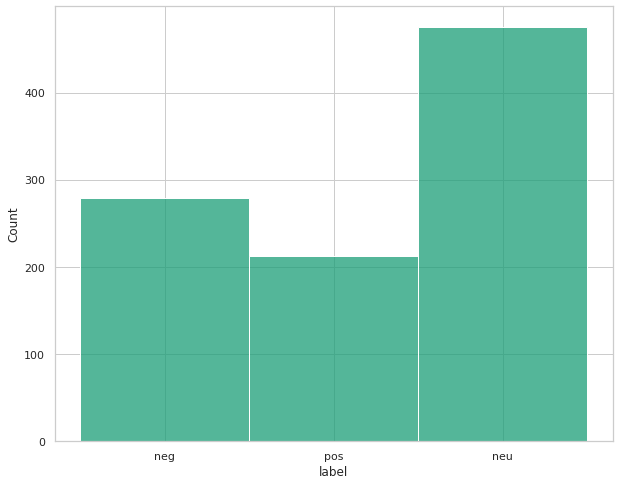

In [ ]:
sns.histplot(news.label);

# View sampled posts based on labels

In [ ]:
def news_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = news.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "pos")

print("\nNeutral news")
news_title_output(news_sub, "neu")

print("\nNegative news")
news_title_output(news_sub, "neg")

Positive news
Man who can't remember his password to unlock $240M in Bitcoins says he has 'made peace' with the loss and moving on
Artificial Intelligence Finds A Strong New Antibiotic For the Very First Time
Starship SN10 has ‘good chance of flying this week’, Elon Musk says
Rural UK users testing Elon Musk’s satellite broadband reveal ‘amazing’ improvement
DoorDash launches gifting feature in time for the holidays

Neutral news
New privacy bill would end law enforcement practice of buying data from brokers
Pentagon officially releases UFO videos
Toshiba Wraps Up Its Laptop Business
Coronavirus is slowing LCD production, and TV and monitor prices are expected to climb as a result
Locally Run ISPs Offer the Fastest Broadband in America

Negative news
Firefox 'Total Cookie Protection' Tries to Block Even More Online Tracking
Apple blocks Facebook update that called out 30-percent App Store ‘tax’
Mother finds fake Facebook ad claiming her family died from coronavirus
Apple products worth

# Tokenize

In [ ]:
text = "Let's see how the NLTK tokenizer works!"

# using word tokenizer
print(nltk.word_tokenize(text))

# using regexp tokenizer
tk = nltk.tokenize.RegexpTokenizer(r'\s+', gaps=True) # split on whitespace
print(tk.tokenize(text))

tk = nltk.tokenize.RegexpTokenizer(r'\w+') # remove punct
print(tk.tokenize(text))

['Let', "'s", 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works', '!']
["Let's", 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works!']
['Let', 's', 'see', 'how', 'the', 'NLTK', 'tokenizer', 'works']


In [ ]:
stop_words = stopwords.words('english')
print(len(stop_words))
print(stop_words[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
def custom_tokenize(text):
  # remove single quote and dashes
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

print(custom_tokenize(text))

['lets', 'see', 'nltk', 'tokenizer', 'works']


In [ ]:
def tokens_2_words(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(news, 'pos')
neg_words = tokens_2_words(news, 'neg')

# Visualize tokens

## Top n words

In [ ]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('apple', 13),
 ('google', 12),
 ('new', 12),
 ('musk', 11),
 ('tech', 11),
 ('first', 11),
 ('free', 10),
 ('elon', 10),
 ('could', 10),
 ('tesla', 10),
 ('000', 9),
 ('twitter', 9),
 ('million', 8),
 ('facebook', 8),
 ('spacex', 8),
 ('says', 8),
 ('help', 8),
 ('support', 7),
 ('years', 7),
 ('5', 7)]

In [ ]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

[('facebook', 36),
 ('apple', 24),
 ('google', 18),
 ('twitter', 15),
 ('us', 15),
 ('new', 14),
 ('hackers', 14),
 ('ban', 13),
 ('amazon', 12),
 ('says', 12),
 ('fcc', 12),
 ('internet', 11),
 ('microsoft', 11),
 ('elon', 11),
 ('data', 10),
 ('u', 10),
 ('musk', 10),
 ('ads', 9),
 ('covid19', 9),
 ('chinese', 9)]

## Word Clouds

In [ ]:
def plot_word_cloud(words, colormap, stopwords = [], max_words = 100):
  text = " ".join(word for word in words)
  # generate word cloud 
  wordcloud = WordCloud(width=1000, height = 600,
                        max_words = max_words,
                        colormap=colormap,
                        stopwords = stopwords,
                        background_color="black").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,10), facecolor='k' )
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

In [ ]:
def extract_sentence_from_word(df, word, label, num = 3):
  contains_word = news['title'].str.contains(r"\b{}\b".format(word), case=False) # matches the word only
  label_type = news['label'] == label
  sent_list = news.loc[contains_word & label_type].title.values
  print("\n".join(sent for sent in sent_list[:num]))

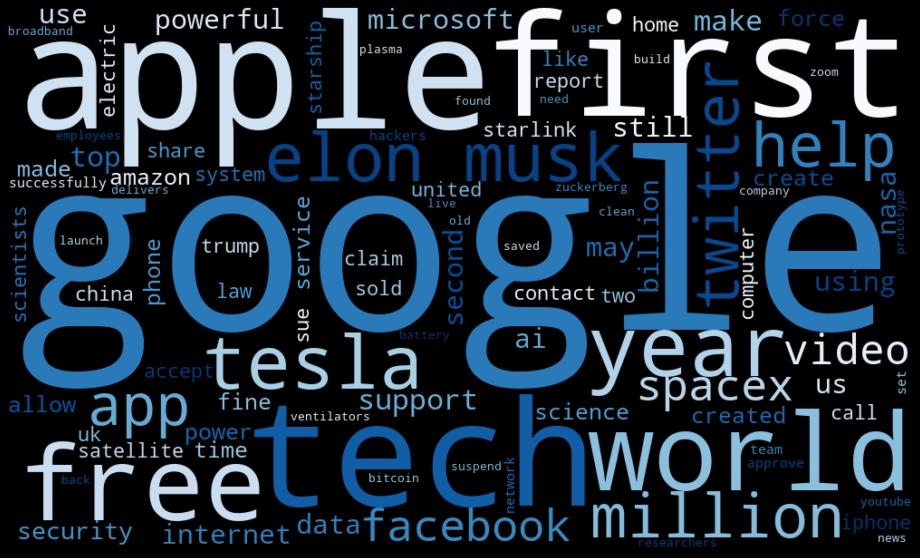

In [ ]:
custom_stopwords = ["new", "could", "say", "says"]
plot_word_cloud(pos_words, "Blues", custom_stopwords)

In [ ]:
extract_sentence_from_word(news, "apple", "pos")

Apple pays out millions in compensation to student after iPhone repair facility shared her explicit personal images online
Toyota president warns Apple that it will need to provide 40 years of support for ‘Apple Car’ - 9to5Mac
Google, Amazon, and Apple have decided to collaborate on a universal smart home ecosystem.


In [ ]:
extract_sentence_from_word(news, "Elon Musk", "pos")

Elon Musk Delivers 1,000 Ventilators to California Hospitals to Treat COVID-19 Patients
Elon Musk’s Australian Battery Farm Has Saved $116 Million AUD In Two Years
Rural UK users testing Elon Musk’s satellite broadband reveal ‘amazing’ improvement


In [ ]:
extract_sentence_from_word(news, "tech", "pos")

Comcast’s president of tech falls offline while boasting about how great cable is for connectivity
Japan to join forces with U.S., Europe in regulating Big Tech firms
Startup founded by ‘Survivor’ champ debuts airless bike tires based on NASA rover tech


In [ ]:
extract_sentence_from_word(news, "world", "pos")

IBM says it has created the world's first 2nm chip. The company claims 2nm processors can use 75 percent less power than 7nm-based CPUs for the same performance
Elon Musk is no longer the world's richest person, according to Forbes, after a fall in Tesla stock wiped $13.5 billion from his fortune in a day
Tesla overtakes Volkswagen as world's second most valuable carmaker


In [ ]:
extract_sentence_from_word(news, "free", "pos")

Google suspends 'free speech' app Parler
Second person cured of HIV is still free of active virus two years on
Hawaii is offering free round trips to remote workers who want to live there temporarily - CNN


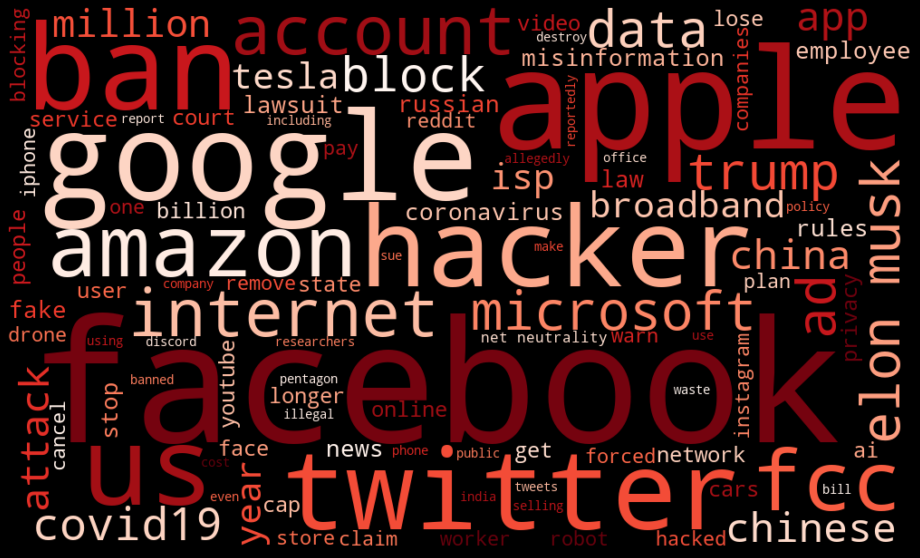

In [ ]:
plot_word_cloud(neg_words, "Reds", custom_stopwords)

In [ ]:
extract_sentence_from_word(news, "ban", "neg", num = 5)

Snapchat will permanently ban Trump’s account
Facebook and Instagram make Trump's ban indefinite
Three years later, Facebook says it will ban QAnon
House Republicans propose nationwide ban on municipal broadband networks
Google and Facebook under pressure to ban children's ads


In [ ]:
extract_sentence_from_word(news, "facebook", "neg")

Trump blocked by Twitter and Facebook
Facebook is finally banning anti-vaxxer misinformation
Facebook and Instagram make Trump's ban indefinite


In [ ]:
extract_sentence_from_word(news, "fcc", "neg")

FCC fines white-supremacist robocaller $10 million for faking caller ID
FCC orders phone companies to help trace illegal robocallers - It's now also putting a limit on non-telemarketing robocalls.
FCC failed to monitor Chinese telecoms for almost 20 years: Senate report


In [ ]:
extract_sentence_from_word(news, "amazon", "neg")

Amazon VP Resigns, Calls Company ‘Chickenshit’ for Firing Protesting Workers
Amazon will no longer reject job applicants who use marijuana
Fired Amazon worker says termination was retaliation for speaking out


In [ ]:
extract_sentence_from_word(news, "internet", "neg")

Hundreds lose internet service in northern B.C. after beaver chews through cable
Microsoft is (finally) killing off Internet Explorer entirely
Myanmar orders internet providers to block Twitter and Instagram in the country
